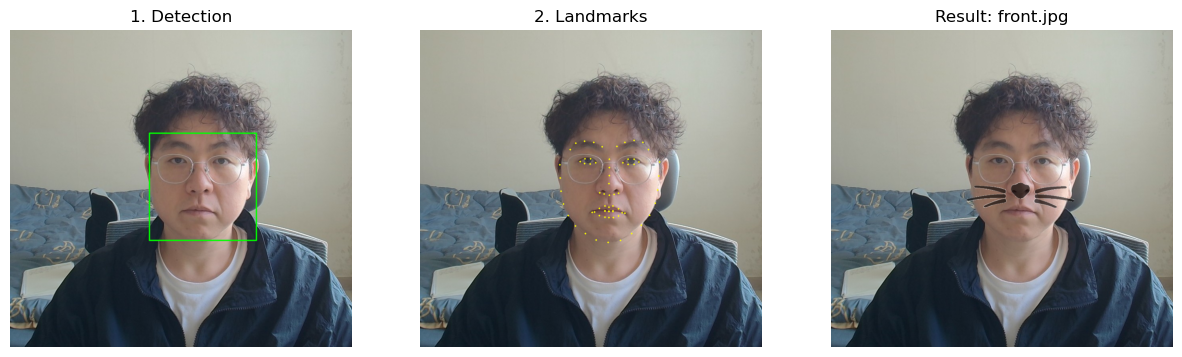

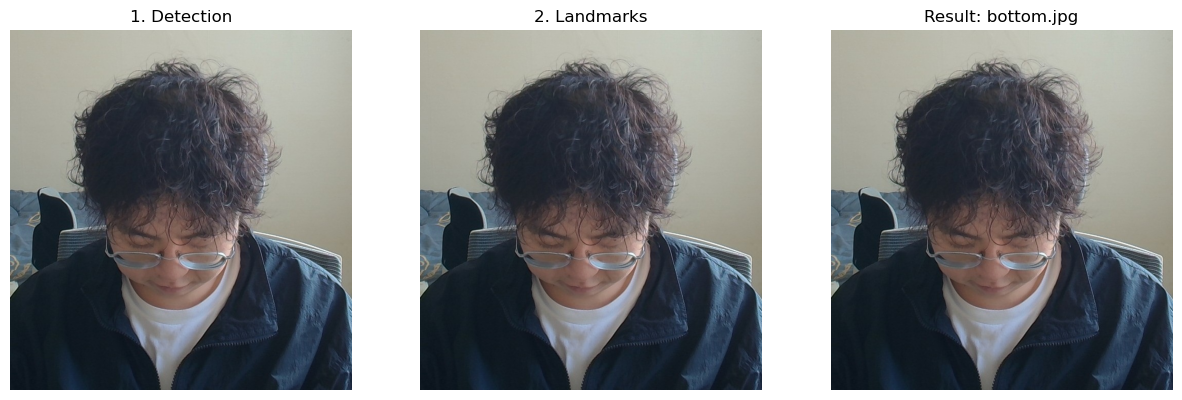

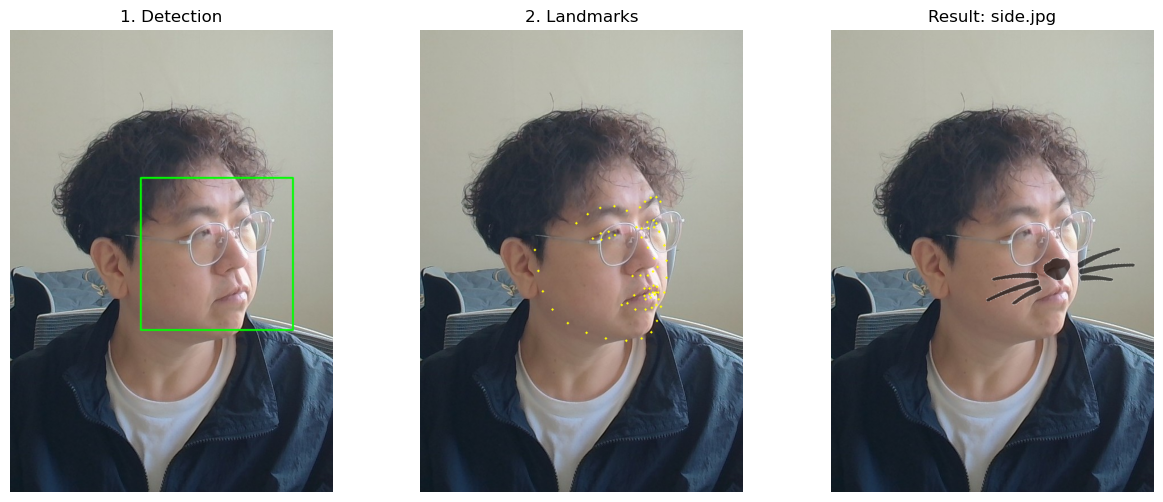

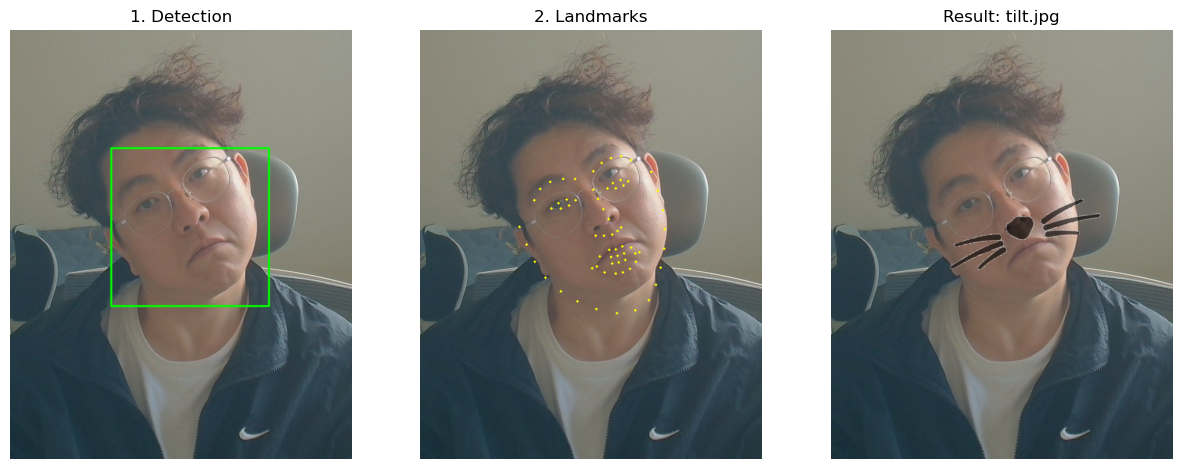

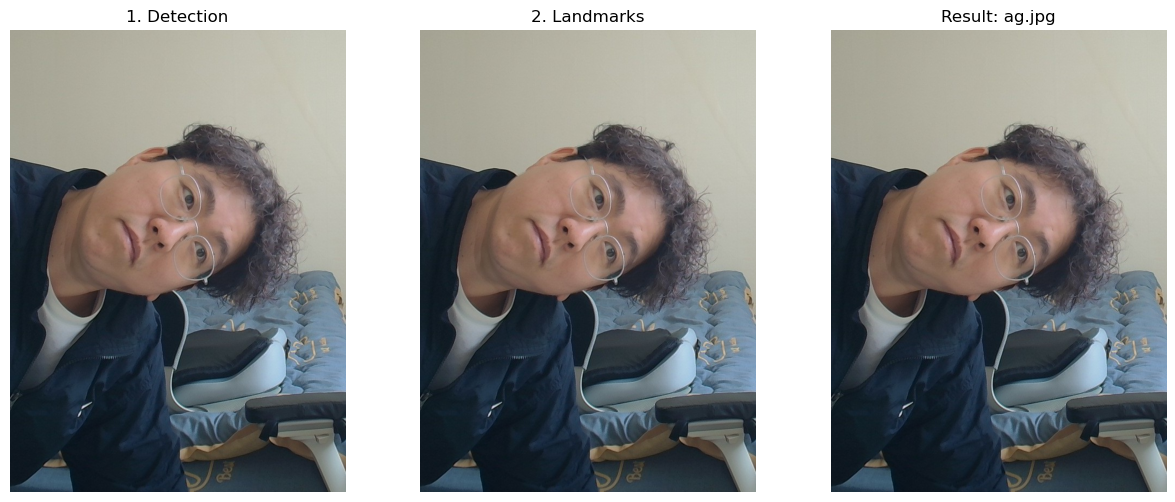

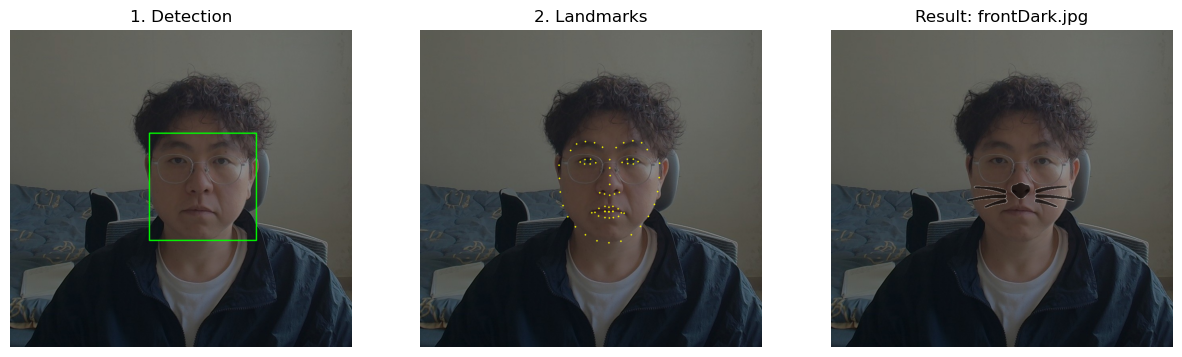

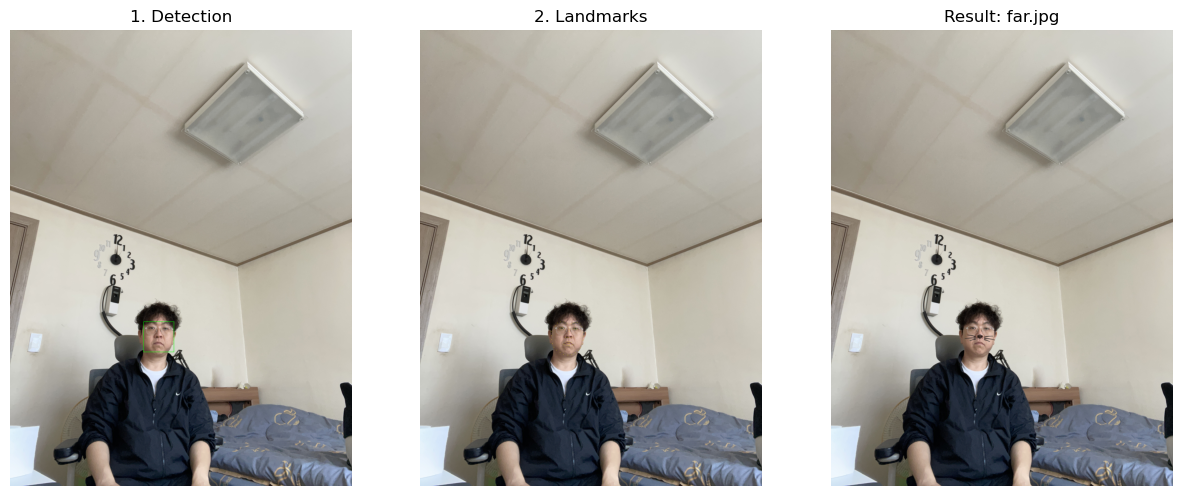

In [19]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리
import math

home_dir = os.getenv('HOME')
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기
# 모델 선언
model_path = os.path.join(home_dir, 'work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
# 점 68개 찾아주는 모델
landmark_predictor = dlib.shape_predictor(model_path)

# 스티커 로드
sticker_path = os.path.join(home_dir, 'work/camera_sticker/images/cat-whiskers.png')
img_sticker_orig = cv2.imread(sticker_path)

# 이미지 폴더 경로 및 파일 리스트 (스티커 파일 및 결과 파일 제외)
image_dir = os.path.join(home_dir, 'work/camera_sticker/images/')
image_files = []

# 모든 jpg파일 추가
for f in os.listdir(image_dir):
    if f.endswith('.jpg'):
        image_files.append(f)

for file_name in image_files:
    image_path = os.path.join(image_dir, file_name)
    img_bgr = cv2.imread(image_path)
    # 이미지를 불러오는 과정에서 문제가 생겼을 때, 넘어가게(pass) 만듬
    if img_bgr is None: continue
    # bgr2rgb 색 바꿈
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다
    # dlib_rects에는 이미지가 저장되지 않는다. 사각형 좌표 정보만 담긴다.
    dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

    # 시각화용 복사본
    img_show_box = img_bgr.copy()
    img_show_landmark = img_bgr.copy()
    img_final = img_bgr.copy()

    #영역 박스 리스트
    for dlib_rect in dlib_rects:
        # 영역 박스안의 값 정함
        # l - 좌
        # t - 상
        # r - 우
        # b - 하
        l, t, r, b = dlib_rect.left(), dlib_rect.top(), dlib_rect.right(), dlib_rect.bottom()
        # 사각형 그리기
        # (0, 255, 0) -> Green 색 테두리
        # 2 -> 선의 두께
        # lineType=cv2.LINE_AA -> Anti Aliasing
        cv2.rectangle(img_show_box, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

        # 점 찾아 주는 모델 
        # landmark_predictor = dlib.shape_predictor(model_path)
        # landmark_predictor(이미지, 사각형)
        # points: 68개 점의 좌표 (x, y)
        points = landmark_predictor(img_rgb, dlib_rect)
        # parts() 메서드를 사용하면, 상자 속에 들어있던 다른 정보들은 무시하고 68개의 점 객체들만 차례대로 꺼내기 좋은 상태로 만들어줍니다.
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        
        for pt in list_points:
            # cv2.circle: OpenCV의 원(작으면 점 처럼 보임)을 그리는 함수
            # img_show_landmark 이미지에
            # pt 점을 찍는다.
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            cv2.circle(img_show_landmark, pt, 2, (0, 255, 255), -1)

        # 눈 위치로 각도 계산 (왼쪽 눈 36번, 오른쪽 눈 45번)
        # 36번과 45번 사이에 차이가 있다는 것 -> 고개를 기울인 것
        # dy 값이 생김
        dy = list_points[45][1] - list_points[36][1]
        dx = list_points[45][0] - list_points[36][0]
        # 아크탄젠트: atan2
        # 이 함수는 삼각함수를 이용해 **기울기를 각도(라디안)**로 바꿔주는 마법 같은 함수입니다.
        # tan(θ) = 높이 / 밑변 
        # 반대로 높이(dy)와 밑변(dx)을 넣어서 각도(θ)를 구하는 것이 아크탄젠트(atan)
        # atan2가 내뱉는 값의 단위는 Radian
        # 하지만 OpenCV는 도(Degree, 0~360도) 단위를 사용.
        angle = math.degrees(math.atan2(dy, dx))

        # 스티커 width, height 같도록 조정
        w = h = dlib_rect.width()
        img_sticker = cv2.resize(img_sticker_orig, (w, h))
        
        # 똑바로 서 있는 스티커를 얼굴 기울기에 맞춰서 회전 (배경은 흰색 255로 채움)
        # (w/2, h/2) (회전 중심): 스티커의 가로(w)와 세로(h)의 절반 지점, 즉 스티커의 정중앙을 축으로 돌리겠다는 뜻
        # 이미지를 돌리려면 어디를 중심으로, 몇 도나 돌릴지 결정하는 '수학적 공식'이 필요한데, 그 공식을 M이라는 행렬에 저장하는 단계.
        M = cv2.getRotationMatrix2D((w/2, h/2), -angle, 1)
        # cv2.warpAffine 설계도대로 실제로 돌리기
        # img_sticker: 회전시킬 대상 이미지.
        # M: 방금 만든 회전 설계도(행렬).
        # (w, h): 결과물 이미지의 크기
        # borderValue=(255, 255, 255) 이미지를 회전시키면 구석에 빈 공간이 생김 그 빈 곳을 어떤 색으로 채울지 정하는 것.
        img_sticker = cv2.warpAffine(img_sticker, M, (w, h), borderValue=(255, 255, 255))
        
        # 위치 계산 (코 끝 33번 중심)
        x, y = list_points[33]
        # 코 좌표에 붙이면 스티커의 왼쪽 상단 모서리부터 시작
        # 사각형 크기의 절반씩 수정 ( - : 땡김)
        refined_x = x - w // 2
        refined_y = y - h // 2
        
        # 스티커의 좌표가 음수가 나올 때 
        if refined_x < 0:
            # 인덱스 슬라이싱 하여 (y, x) 이미지 crop
            img_sticker = img_sticker[:, -refined_x:]
            # 넘쳐 나가더라도 시작 좌표 0으로 고정
            refined_x = 0
        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0

        # 투명도(Alpha)
        # 원본 이미지에서 스티커가 붙을 자리만큼의 배경을 잠시 떼어내는 작업.
        # 이를 전문 용어로 ROI(Region of Interest, 관심 영역) 설정이라고 부른다.
        # Slicing
        # roi 에는 원본 이미지의 일부를 복사한 작은 이미지 데이터(행렬) 담김.
        roi = img_final[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        
        # 투명도 설정
        alpha = 0.6
        # 스티커의 흰색 부분(255)은 배경을 그대로 두고, 아닌 부분만 투명도 적용 합성
        # all: 어디가 흰색 배경이고, 어디가 진짜 수염인지
        # all: 한 픽셀 안에 들어있는 B, G, R 값이 모두(all) 255인가?
        # 이미지는 (세로, 가로, 색상채널) 형태의 3차원 배열입니다
        # axis=-1 가장 마지막 축, 즉 (B, G, R) 색상 정보가 들어있는 축
        # mask는 이미지와 똑같은 가로/세로 크기를 가진 True/False로 이루어진 지도가 만들어짐
        mask = np.all(img_sticker == 255, axis=-1) # 흰색 배경 마스크
        
        # 투명도가 적용된 블렌딩 이미지 생성
        # cv2.addWeighted(사진1, 가중치1, 사진2, 가중치2, 추가합계)
        # roi 스티커가 붙을 자리에서 미리 오려둔 원본 배경 조각
        # 0 (gamma): 합친 결과에 마지막으로 더해줄 상수값인데, 보통 밝기를 조절할 때 쓰지만 여기서는 0을 넣어 아무 작업도 하지 않습니다.
        blended = cv2.addWeighted(roi, 1 - alpha, img_sticker, alpha, 0)
        
        # mask: 아까 만든 "흰색 배경은 True"인 지도.
        # ~mask: 흰색이 아닌 부분(진짜 수염 부분)
        # roi라는 배경 조각에서 수염이 위치할 자리(~mask)에만, 방금 만든 합성(blended)을 덮어씌움
        roi[~mask] = blended[~mask]
        # 원본 사진의 아까 그 자리에 수염을 붙인 새로운 조각을 다시 갖다 붙임
        img_final[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = roi

    # 결과 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    axes[0].imshow(cv2.cvtColor(img_show_box, cv2.COLOR_BGR2RGB))
    axes[0].set_title("1. Detection")
    axes[1].imshow(cv2.cvtColor(img_show_landmark, cv2.COLOR_BGR2RGB))
    axes[1].set_title("2. Landmarks")
    axes[2].imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f"Result: {file_name}")
    # 그래프가 아니라 사진 처럼 보이게 숫자(눈금선이나 눈금 숫자)를 지워버림
    for ax in axes: ax.axis('off')
    plt.show()

### 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    스티커의 각도도 변해야 합니다. 눈 양 끝과 같은 각도를 잘 나타낼 수 있는 기준점을 잡고
    둘의 차이를 구한 다음 아크탄젠트를 사용하여 각도를 추출하여
    각도만큼 rotation 시켜야 합니다.

### 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    특징점 소실: 얼굴이 너무 멀리 있으면 눈은 고작 1~2픽셀, 코는 점 하나 수준으로 보입니다. 
    dlib의 68개 점을 찍으려면 눈매의 곡선, 콧망울의 두께 등이 보여야 하는데, 
    정보 자체가 부족하니 점 위치가 빗나가거나 아예 얼굴로 인식하지 못하게 됩니다.

    정립 보행 기준: dlib의 얼굴 탐지 모델은 수만 장의 사람 사진을 보고 공부했습니다. 
    그런데 대부분의 사진 속 사람들은 고개를 똑바로 세우고 있죠.
    
### 실행 속도가 중요할까요?
    제일 마지막 사진인 약간 멀리서 찍은 사진 같은 경우에는 출력하는데
    시간이 오래 걸렸습니다. 실행 속도가 중요할 것으로 보이며
    실시간 영상에 적용하려면 더더욱 속도가 중요할 것 같습니다.
### 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
    이상한 위치에 얼굴이 표시 되면 무섭기 때문에 중요합니다. ^^;